In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
%matplotlib inline

In [8]:
imdb = pd.read_csv('Train.csv')

In [9]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [10]:
imdb.shape

(40000, 2)

In [11]:
imdb.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [12]:
# make a graph showing percentages of 0s and 1s

In [13]:
from sklearn.model_selection import train_test_split

features = imdb.drop("label",axis=1)
labels = imdb["label"]

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.90, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size = 0.5, random_state=42)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

Data distribution:
- Train: 2000 
- Validation: 1000 
- Test: 1000


Now let's create a function that will pre-process and clean the data. It does the following:
- Tokenize sentences
- Remove capital letters
- Remove stopwords
- Remove non-alphanumeric characters
- Lemmatize the tokens

In [14]:
def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

Processing data...
Creating word clouds...


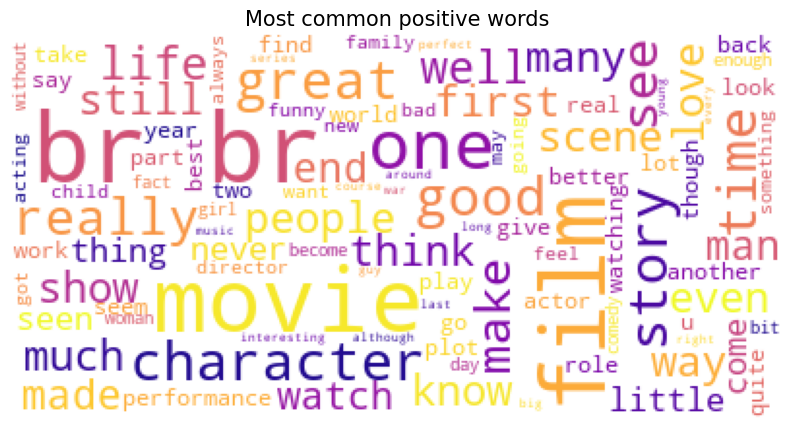

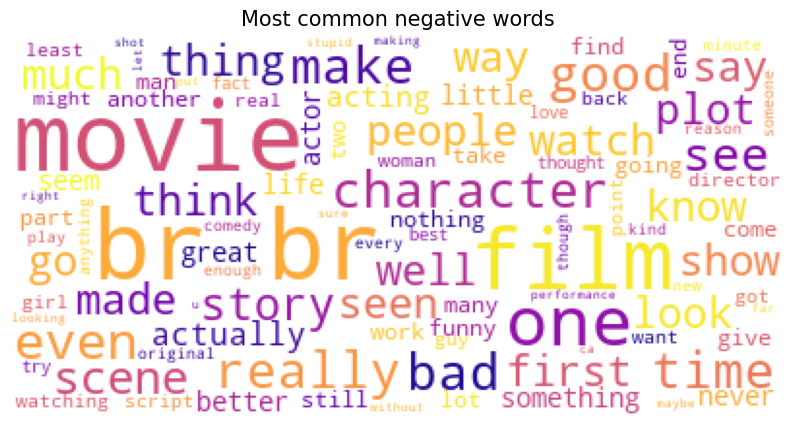

In [22]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(10,8))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=15)
    plt.imshow(wc.recolor(colormap='plasma', random_state=17), alpha=0.98)
    plt.axis('off')
    
imdb=imdb.head(1000)
print("Processing data...")
imdb['clean']=imdb['text'].map(clean)
imdb['clean_text']=imdb['clean'].apply(lambda x: " ".join([str(word) for word in x]))

print("Creating word clouds...")
positive_words=" ".join(imdb[imdb.label==1]['clean_text'].values)
negative_words=" ".join(imdb[imdb.label==0]['clean_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [27]:
tfidf_vect = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit=tfidf_vect.fit(X_train['text'])
X_train=vectorize(X_train['text'],tfidf_vect_fit)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
scores = cross_val_score(rf,X_train,y_train.values.ravel(),cv=5)

In [29]:
print(scores)
scores.mean()

[0.795 0.785 0.785 0.805 0.81 ]


0.796

Now we'll do some hyperparameter tuning using GridSearchCV.

In [30]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [31]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': 20, 'n_estimators': 100}

0.541 (+/-0.052) for {'max_depth': 2, 'n_estimators': 5}
0.703 (+/-0.026) for {'max_depth': 2, 'n_estimators': 50}
0.744 (+/-0.031) for {'max_depth': 2, 'n_estimators': 100}
0.625 (+/-0.061) for {'max_depth': 10, 'n_estimators': 5}
0.76 (+/-0.012) for {'max_depth': 10, 'n_estimators': 50}
0.792 (+/-0.026) for {'max_depth': 10, 'n_estimators': 100}
0.674 (+/-0.045) for {'max_depth': 20, 'n_estimators': 5}
0.781 (+/-0.022) for {'max_depth': 20, 'n_estimators': 50}
0.802 (+/-0.034) for {'max_depth': 20, 'n_estimators': 100}
0.644 (+/-0.038) for {'max_depth': None, 'n_estimators': 5}
0.774 (+/-0.04) for {'max_depth': None, 'n_estimators': 50}
0.794 (+/-0.028) for {'max_depth': None, 'n_estimators': 100}


In [32]:
cv.best_estimator_

RandomForestClassifier(max_depth=20)

For the evaluation of the validation set, first we need to transform it using the same features as the training set. Then, we can evaluate our best models from CV on it.

In [33]:
X_val=vectorize(X_val['text'],tfidf_vect_fit)

In [34]:
rf1 = RandomForestClassifier(n_estimators=100,max_depth=20)
rf1.fit(X_train, y_train.values.ravel())
rf2 = RandomForestClassifier(n_estimators=100,max_depth=None)
rf2.fit(X_train, y_train.values.ravel())
rf3 = RandomForestClassifier(n_estimators=5,max_depth=None)
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=5)

In [35]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

for mdl in [rf1,rf2,rf3]:
    y_pred = mdl.predict(X_val)
    accuracy = round(accuracy_score(y_val,y_pred), 3)
    precision = round(precision_score(y_val,y_pred), 3)
    recall = round(recall_score(y_val,y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

MAX DEPTH: 20 / # OF EST: 100 -- A: 0.819 / P: 0.812 / R: 0.82
MAX DEPTH: None / # OF EST: 100 -- A: 0.832 / P: 0.823 / R: 0.836
MAX DEPTH: None / # OF EST: 5 -- A: 0.676 / P: 0.669 / R: 0.669


Hence the second model is the best one

Now, evaluating the best model on the test set

In [36]:
X_test=vectorize(X_test['text'],tfidf_vect_fit)

y_pred = rf2.predict(X_test)
accuracy = round(accuracy_score(y_test,y_pred), 3)
precision = round(precision_score(y_test,y_pred), 3)
recall = round(recall_score(y_test,y_pred), 3)
print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(rf3.max_depth,
                                                                     rf3.n_estimators,
                                                                     accuracy,
                                                                     precision,
                                                                     recall))

MAX DEPTH: None / # OF EST: 5 -- A: 0.808 / P: 0.816 / R: 0.775


We can also see the most important words to see the correct results

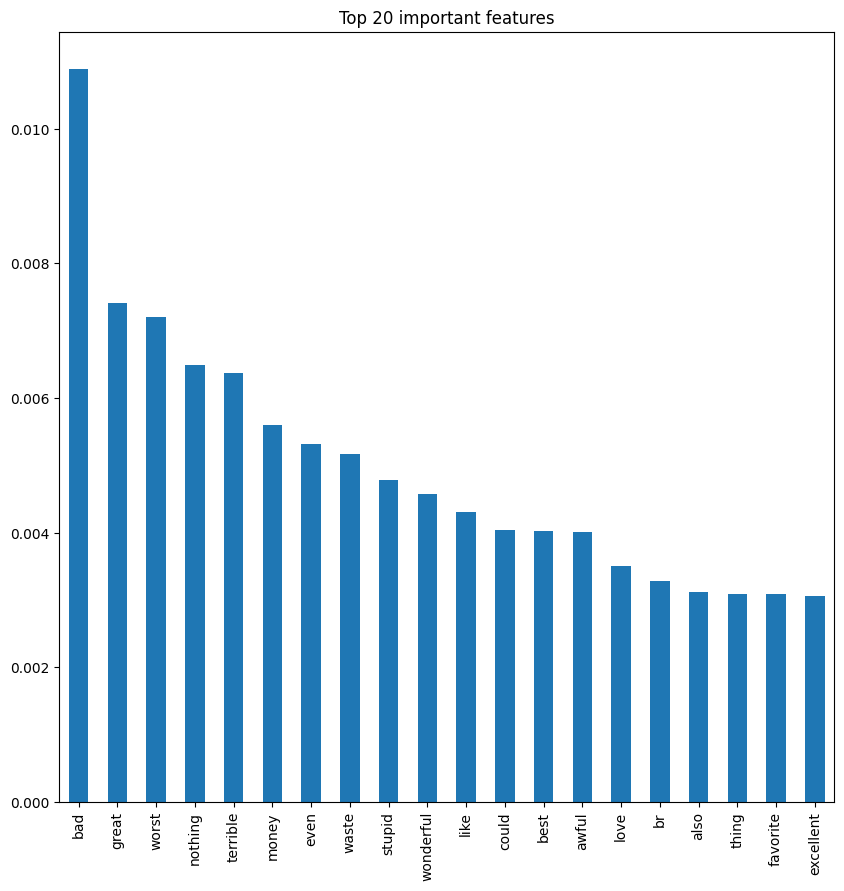

In [37]:
feat_importances = pd.Series(rf2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.show()